### Loading in and analyzing the tensors from the MHA layers of Gemma

In [32]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch

#### Load in Data

In [14]:
folder = "scores_by_layer/"
layer_num = 0

# Load the .pt file
data = torch.load(f'{folder}layer_{layer_num}_scores.pt') # list of np arrays

# Concatenate the list of NumPy arrays
all_values = np.concatenate([arr.flatten() for arr in data])

/var/folders/89/7jyts_994cx65pjfv4x2jr4w0000gn/T/ipykernel_48223/4109990673.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(f'{folder}layer_{layer_num}

#### Analysis

In [17]:
# filter out masked values
mask_threshold = -2e38
filtered_values = all_values[(all_values > mask_threshold)]

print(f"Percentage of values unmasked: {(len(filtered_values) / len(all_values) * 100):2f}%.")

Percentage of values unmasked: 50.000000%.


In [18]:
# Basic statistical analysis
print("Descriptive Statistics:")
print("Mean:", np.mean(filtered_values))
print("Median:", np.median(filtered_values))
print("Standard Deviation:", np.std(filtered_values))
print("Min:", np.min(filtered_values))
print("Max:", np.max(filtered_values))

Descriptive Statistics:
Mean: -1.7127855
Median: -1.3359375
Standard Deviation: 3.0535126
Min: -25.625
Max: 14.1875


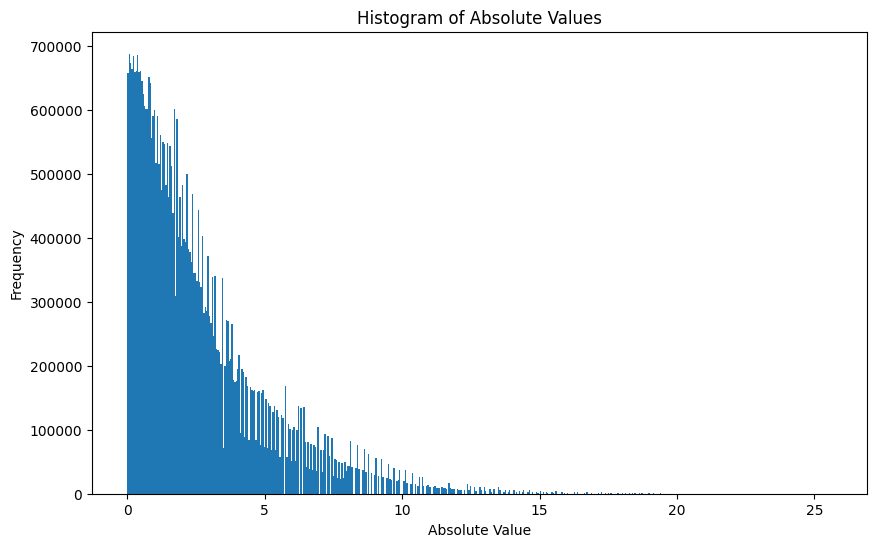

In [20]:
# Plotting histogram of absolute values
plt.figure(figsize=(10, 6))
plt.hist(np.abs(filtered_values), bins=500)
plt.title('Histogram of Absolute Values')
plt.xlabel('Absolute Value')
plt.ylabel('Frequency')
plt.show()

/var/folders/89/7jyts_994cx65pjfv4x2jr4w0000gn/T/ipykernel_48223/626895530.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(f'{folder}layer_{layer_num}

Layer 0: 50.00% values unmasked
Layer 1: 50.00% values unmasked
Layer 2: 50.00% values unmasked
Layer 3: 50.00% values unmasked
Layer 4: 50.00% values unmasked
Layer 5: 50.00% values unmasked
Layer 6: 50.00% values unmasked
Layer 7: 50.00% values unmasked
Layer 8: 50.00% values unmasked
Layer 9: 50.00% values unmasked
Layer 10: 50.00% values unmasked
Layer 11: 50.00% values unmasked
Layer 12: 50.00% values unmasked
Layer 13: 50.00% values unmasked
Layer 14: 50.00% values unmasked
Layer 15: 50.00% values unmasked
Layer 16: 50.00% values unmasked
Layer 17: 50.00% values unmasked
Layer 18: 50.00% values unmasked
Layer 19: 50.00% values unmasked
Layer 20: 50.00% values unmasked
Layer 21: 50.00% values unmasked
Layer 22: 50.00% values unmasked
Layer 23: 50.00% values unmasked
Layer 24: 50.00% values unmasked
Layer 25: 50.00% values unmasked


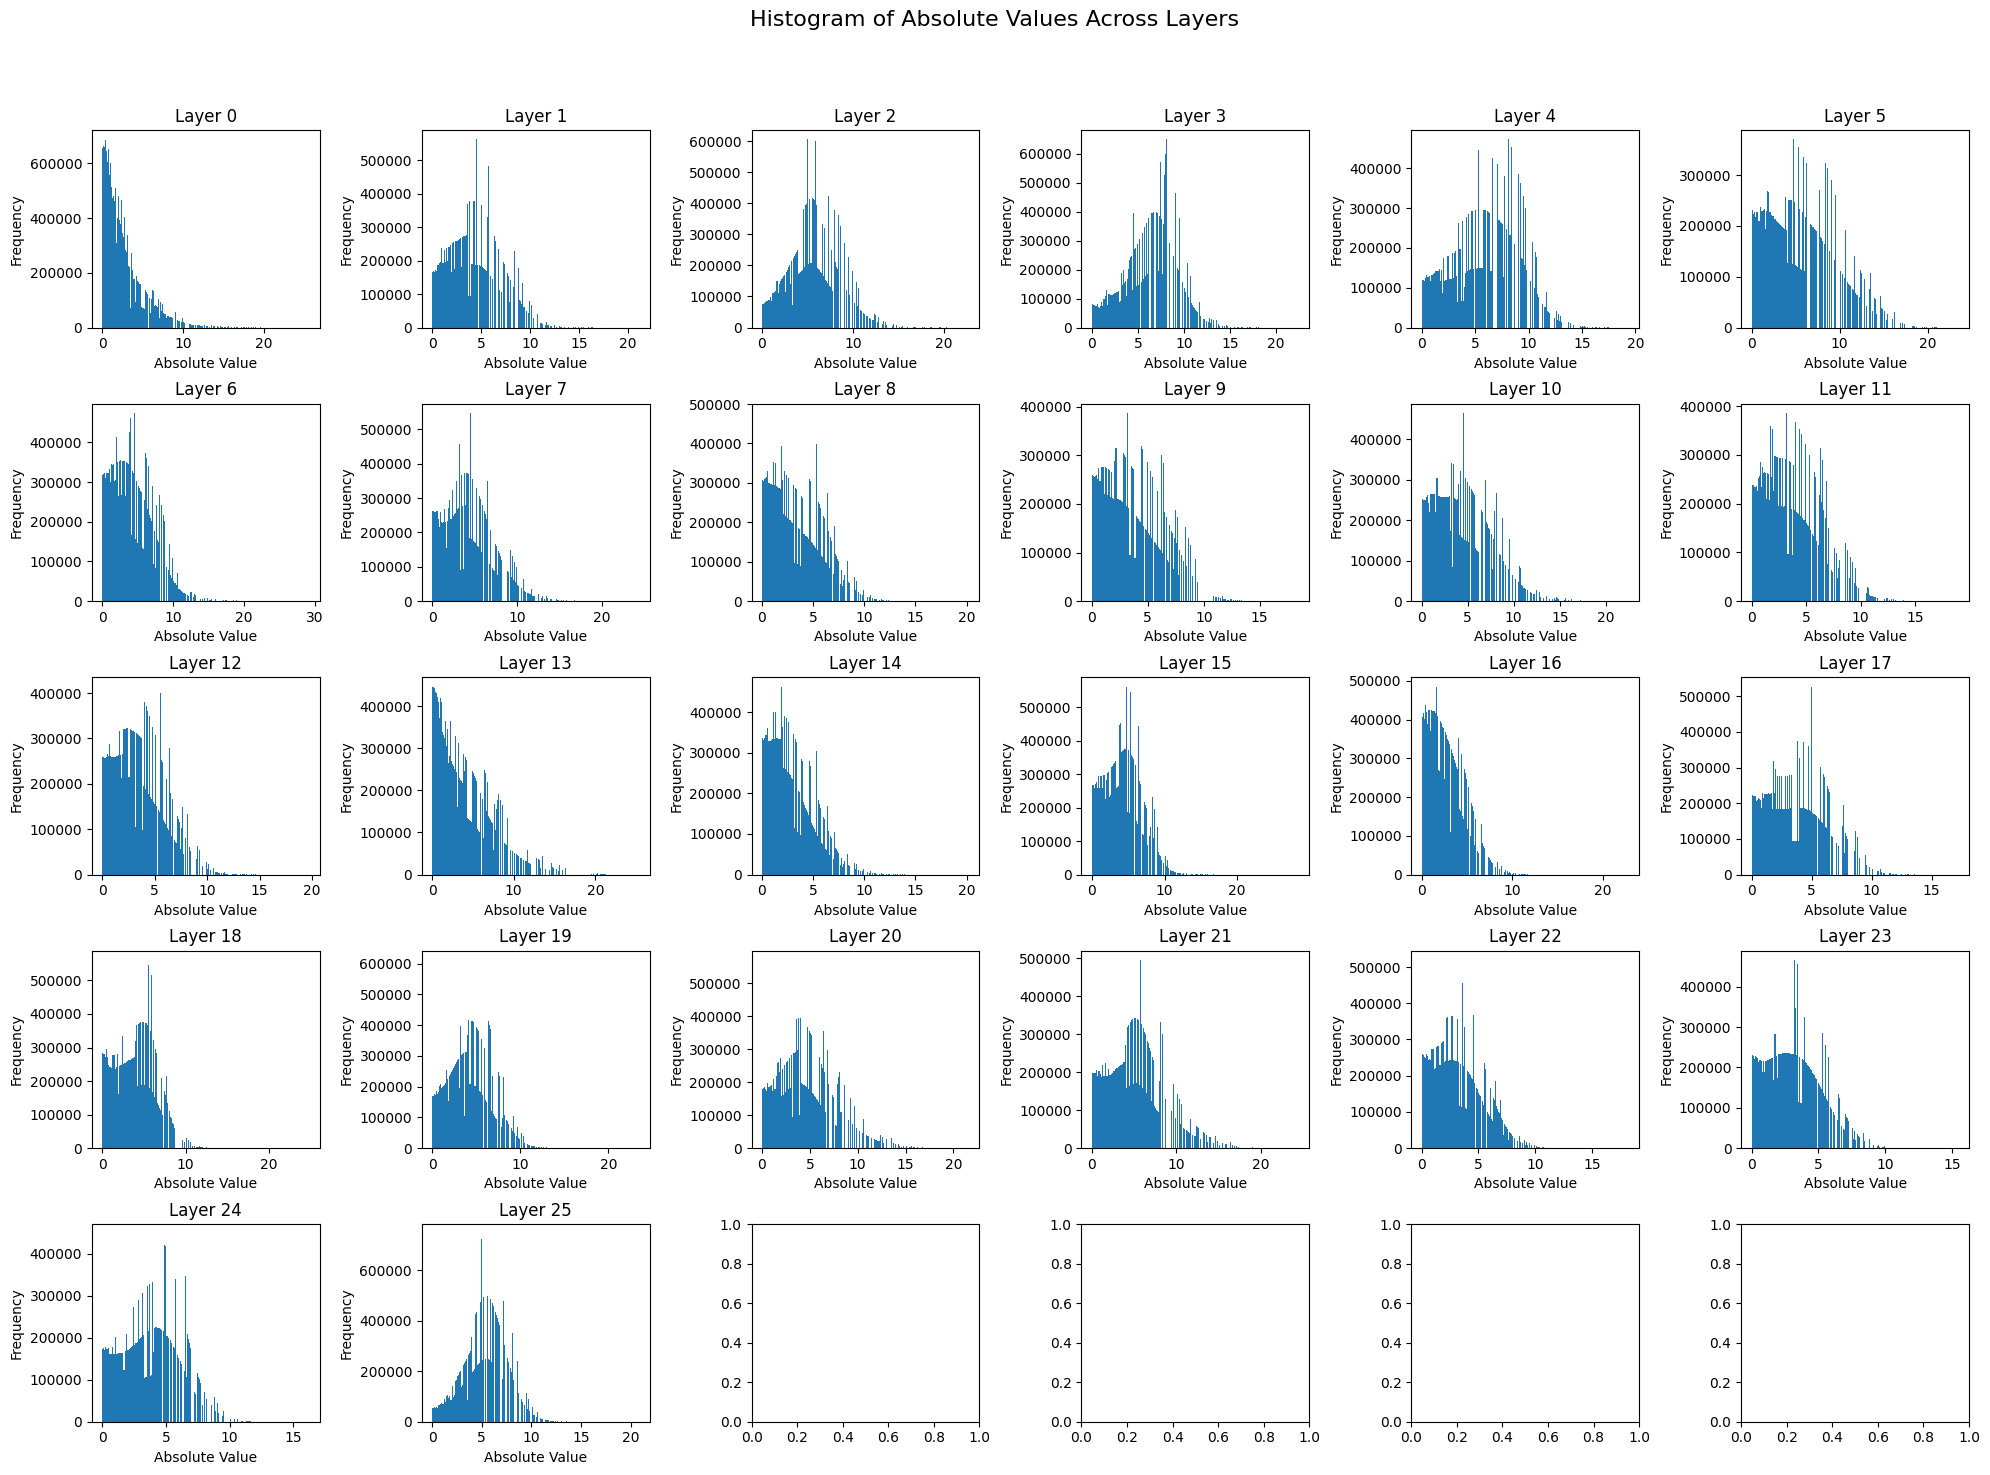

In [22]:
def process_layer_scores(folder="scores_by_layer/", min_layer=0, max_layer=25, mask_threshold=-2e38):
    """
    Load and visualize scores for multiple layers
    
    Parameters:
    -----------
    folder : str, optional
        Folder containing layer score files
    min_layer : int, optional
        Starting layer number
    max_layer : int, optional
        Ending layer number
    mask_threshold : float, optional
        Threshold for filtering out masked values
    """
    # Create a grid of subplots
    fig, axes = plt.subplots(5, 6, figsize=(20, 15))
    fig.suptitle('Histogram of Absolute Values Across Layers', fontsize=16)
    axes = axes.flatten()  # Flatten for easier indexing

    # Process each layer
    for layer_num in range(min_layer, max_layer + 1):
        try:
            # Load the .pt file for the current layer
            data = torch.load(f'{folder}layer_{layer_num}_scores.pt')
            
            # Concatenate the list of NumPy arrays
            all_values = np.concatenate([arr.flatten() for arr in data])
            
            # Filter out masked values
            filtered_values = all_values[(all_values > mask_threshold)]
            
            # Calculate unmasking percentage
            unmask_percentage = (len(filtered_values) / len(all_values) * 100)
            
            # Plot histogram of absolute values
            ax = axes[layer_num]
            ax.hist(np.abs(filtered_values), bins=500)
            ax.set_title(f'Layer {layer_num}')
            ax.set_xlabel('Absolute Value')
            ax.set_ylabel('Frequency')
            
            print(f"Layer {layer_num}: {unmask_percentage:.2f}% values unmasked")
        
        except FileNotFoundError:
            print(f"Warning: File for layer {layer_num} not found")
        except Exception as e:
            print(f"Error processing layer {layer_num}: {e}")
    
    # Adjust layout and display
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for suptitle
    plt.show()

# Run the visualization
process_layer_scores()

In [55]:
def populate_paws_dict(min_layer=0, max_layer=25, mask_threshold=-2e38, start_percentile=0, stop_percentile=101, step_percentile=5):
    """
    Structure of resulting dict is layer_num -> percentile -> threshold_value
    """
    paws_dict = {}

     # Process each layer
    for layer_num in range(min_layer, max_layer + 1):
        try:
            # Load the .pt file for the current layer
            data = torch.load(f'{folder}layer_{layer_num}_scores.pt')
            
            # Concatenate the list of NumPy arrays
            all_values = np.concatenate([arr.flatten() for arr in data])
            
            # Filter out masked values
            filtered_values = all_values[(all_values > mask_threshold)]
            
            # take abs
            filtered_values = np.abs(filtered_values)

            # Generate percentiles
            percentiles = [int(p) for p in np.arange(start_percentile, stop_percentile, step_percentile)]
            
            # Calculate percentile values
            percentile_values = np.percentile(filtered_values, percentiles)
            
            # Create a dictionary mapping percentiles to their values
            percentile_dict = dict(zip(percentiles, percentile_values))
            
            paws_dict[layer_num] = percentile_dict


        except FileNotFoundError:
            print(f"Warning: File for layer {layer_num} not found")
        except Exception as e:
            print(f"Error processing layer {layer_num}: {e}")

    return paws_dict

In [58]:
paws_dict = populate_paws_dict()
paws_dict

/var/folders/89/7jyts_994cx65pjfv4x2jr4w0000gn/T/ipykernel_48223/2453735178.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(f'{folder}layer_{layer_num

{0: {0: 2.9802322387695312e-08,
  5: 0.1640625,
  10: 0.328125,
  15: 0.494140625,
  20: 0.66796875,
  25: 0.84765625,
  30: 1.03125,
  35: 1.234375,
  40: 1.4453125,
  45: 1.671875,
  50: 1.90625,
  55: 2.15625,
  60: 2.421875,
  65: 2.734375,
  70: 3.09375,
  75: 3.546875,
  80: 4.0625,
  85: 4.8125,
  90: 5.78125,
  95: 7.375,
  100: 25.625},
 1: {0: 2.384185791015625e-07,
  5: 0.5234375,
  10: 1.0,
  15: 1.4375,
  20: 1.859375,
  25: 2.25,
  30: 2.640625,
  35: 3.015625,
  40: 3.390625,
  45: 3.765625,
  50: 4.125,
  55: 4.46875,
  60: 4.78125,
  65: 5.15625,
  70: 5.53125,
  75: 5.96875,
  80: 6.40625,
  85: 6.9375,
  90: 7.625,
  95: 8.625,
  100: 21.125},
 2: {0: 4.76837158203125e-07,
  5: 1.1484375,
  10: 1.953125,
  15: 2.578125,
  20: 3.109375,
  25: 3.59375,
  30: 3.984375,
  35: 4.375,
  40: 4.6875,
  45: 5.03125,
  50: 5.34375,
  55: 5.6875,
  60: 6.0,
  65: 6.34375,
  70: 6.75,
  75: 7.1875,
  80: 7.625,
  85: 8.1875,
  90: 9.0625,
  95: 10.1875,
  100: 22.75},
 3: {0: 2.

In [59]:
export_path = "paws_dict/paws_dict.json"

with open(export_path, 'w') as f:
    json.dump(paws_dict, f, indent=4)
print(f"Percentile values exported to {export_path}")

Percentile values exported to paws_dict/paws_dict.json
